In [1]:
import pandas as pd
import torch
import torch.nn as nn
import scipy.stats as sps
import copy
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
from tqdm import tqdm
from typing import List
from matplotlib import cm

import seaborn as sns

sns.set_style("whitegrid")

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
print(device)

cuda:0


## Генерация синтетической выборки


In [3]:
c0 = 0.2
w0 = 0.3


def usefulness(c, w, noice):
    # return  np.exp(-((c - c0)**2 +(w - w0)**2  + noice**2)) * 0.95
    return np.arctan(c - w + noice) / np.pi + 0.5


def L(u_true, u_pred):
    return (u_true - u_pred) ** 2


customer_distribution = sps.norm(0.6, 0.2)
w_distribution = sps.norm(0, 0.4)

epsilon = sps.norm(0, 0.05)


In [4]:
from models.u_predictor import NeuralNetwork, FeedbackDataset
from models.u_predictor import dynamic_system_iterate_u
from models.u_predictor import init_data

In [5]:
start_c_size = 64
start_w_size = 64
z = lambda: epsilon.rvs()
train_data_loader, c_w_distribution = init_data(customer_distribution, w_distribution, start_c_size, start_w_size,
                                                usefulness, z)


def init_model():
    loss_func = torch.nn.BCELoss()
    model = NeuralNetwork(device, loss_func).to(device)
    model.set_optimizer(torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999)))
    model.fit_epoch(train_data_loader)
    return model

In [17]:
num_of_iterations = 101

In [18]:
# model.recommend_topN()

In [19]:
def execute_experiment(model, c_w_distribution, num_of_iterations, freq=1, u_pred_case=1, topn=4):
    new_c_w_distr = copy.deepcopy(c_w_distribution)
    loss_history = []
    accuracy = []
    residual_history = []
    L_val = []
    mean_history = []
    variance_history = []
    c_size = 256
    w_size = 512
    fig, axs = plt.subplots(ncols=2)
    for i in tqdm(range(num_of_iterations)):
        z = lambda: epsilon.rvs() / (i + 1)
        if i % freq == 0:
            new_c_w_distr, accuracy_at4, loss, L_mean, residual, mean, variance = dynamic_system_iterate_u(model, usefulness, z, L,
                                                                                           new_c_w_distr,
                                                                                           u_pred_case=u_pred_case,
                                                                                           c_size=c_size,
                                                                                           w_size=w_size, topn=topn,
                                                                                           visualize_distributions=(
                                                                                           i, axs))
        else:
            new_c_w_distr, accuracy_at4, loss, L_mean, residual, mean, variance = dynamic_system_iterate_u(model, usefulness, z, L,
                                                                                           new_c_w_distr,
                                                                                           u_pred_case=u_pred_case,
                                                                                           c_size=c_size,
                                                                                           w_size=w_size, topn=topn)
        loss_history.append(loss)
        accuracy.append(accuracy_at4)
        residual_history.append(residual)
        L_val.append(L_mean)
        mean_history.append(mean)
        variance_history.append(variance)
    fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.show()
    return loss_history, accuracy, residual_history, L_val, mean_history, variance_history

## Запуск итераций для NN


In [22]:
model = init_model()

100%|██████████| 26/26 [00:42<00:00,  1.62s/it]
/tmp/ipykernel_8495/1290633780.py:35: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


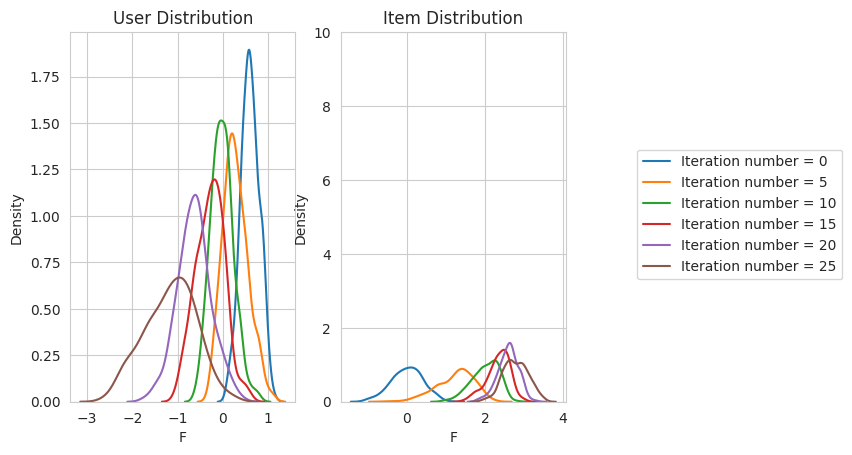

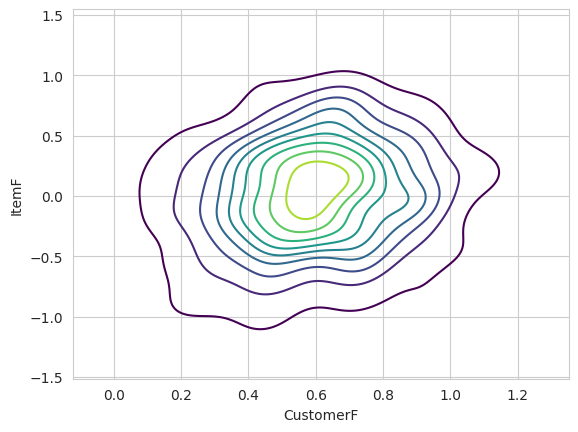

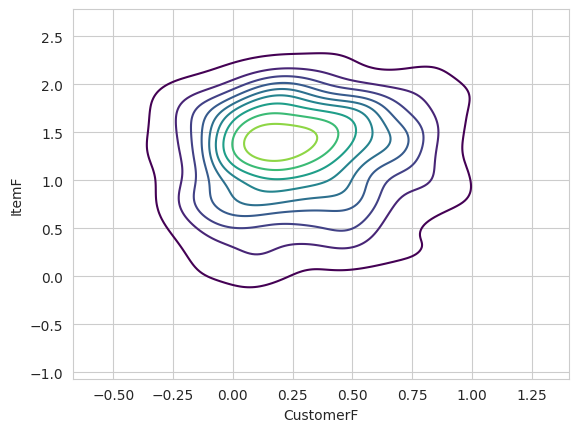

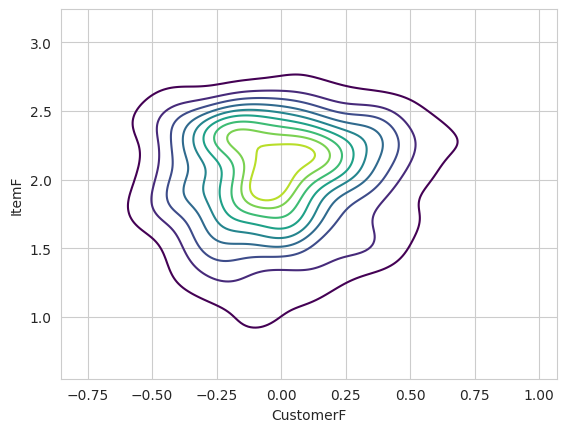

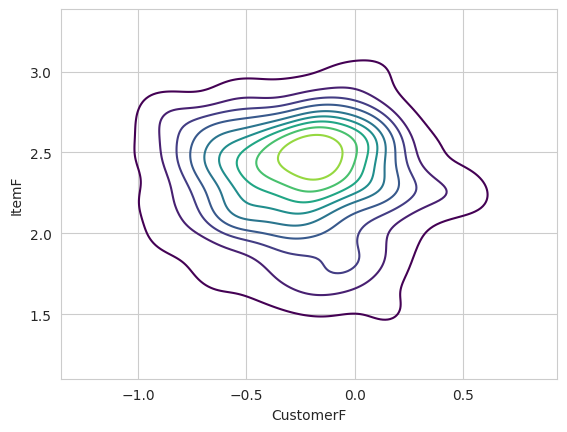

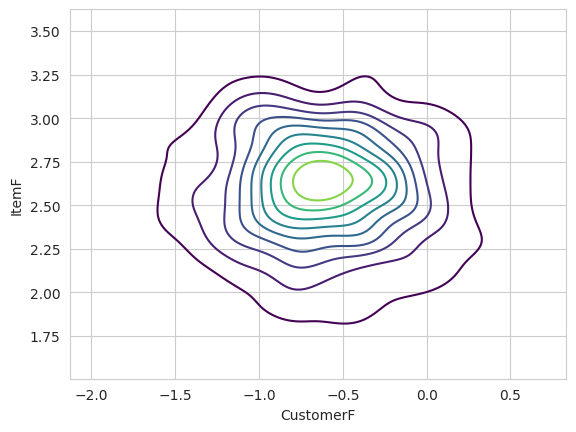

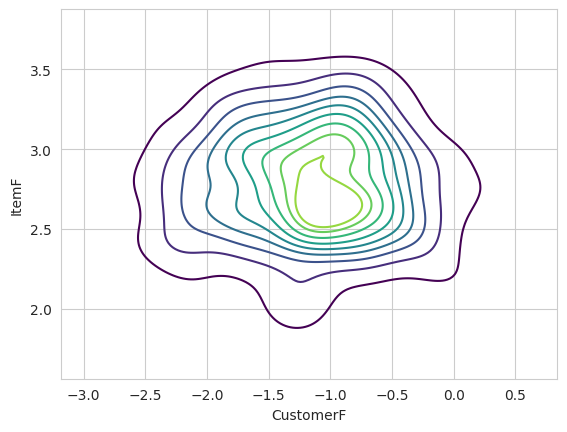

In [23]:
loss_history_2, accuracy_2, residual_history_2, L_val_2, mean_2, variance_2 = execute_experiment(model, c_w_distribution, 26, freq=5,
                                                                             u_pred_case=2)

In [11]:
model = init_model()

100%|██████████| 26/26 [00:32<00:00,  1.26s/it]
/tmp/ipykernel_8495/1290633780.py:35: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


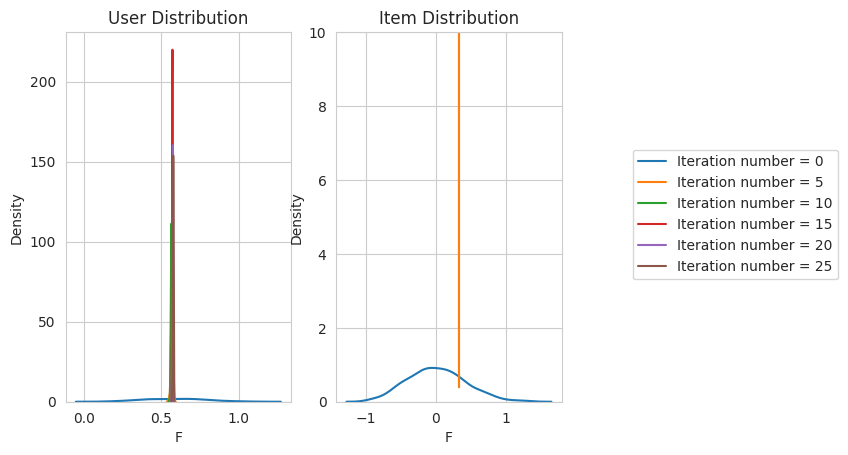

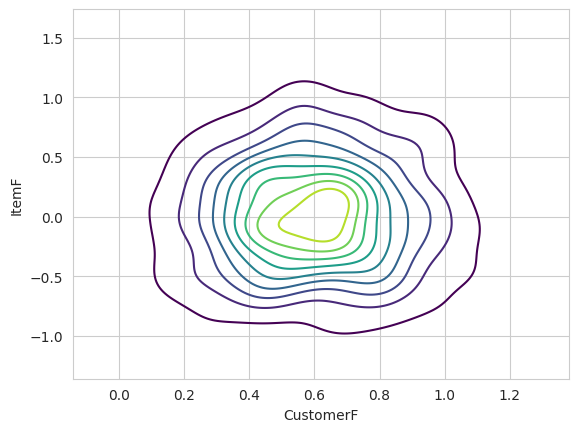

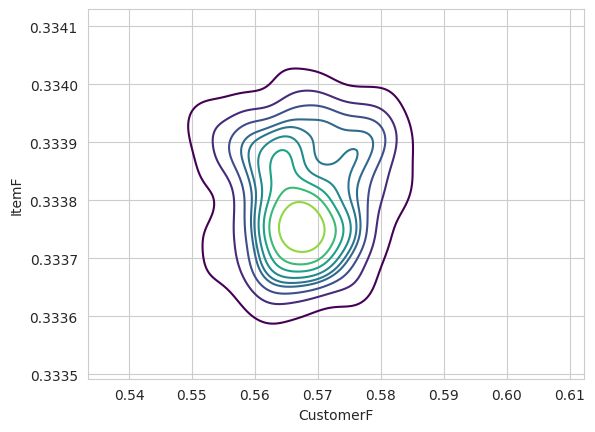

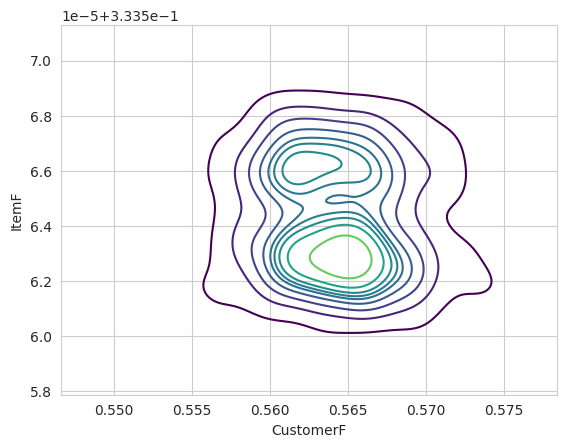

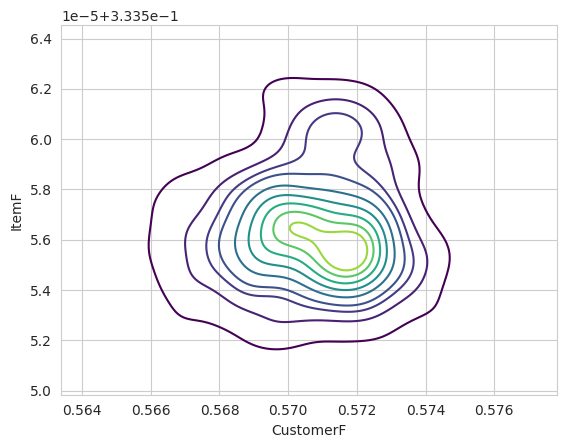

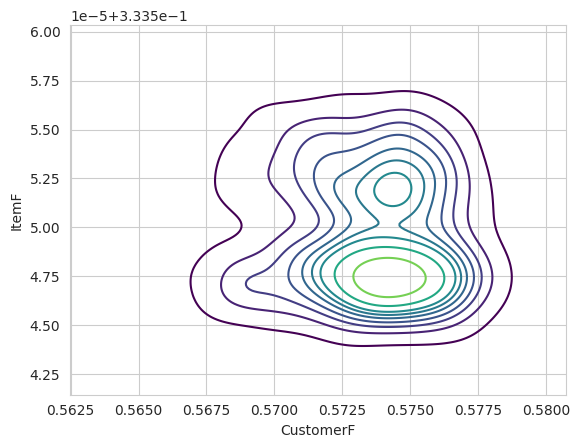

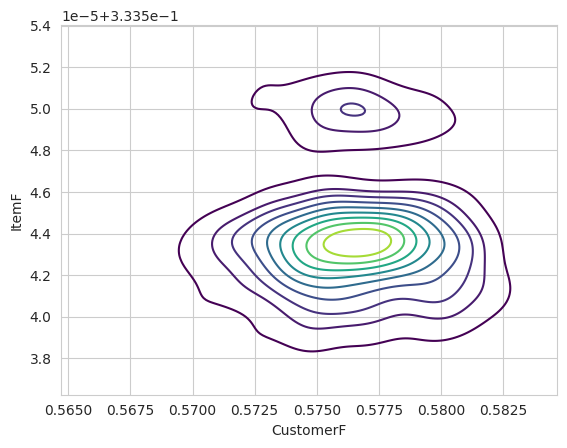

In [21]:
loss_history_1, accuracy_1, residual_history_1, L_val_1, mean_1, variance_1 = execute_experiment(model, c_w_distribution, 26, freq=5,
                                                                             u_pred_case=1)

In [13]:
mean_1 = np.array(mean_1).T
mean_2 = np.array(mean_2).T
variance_1 = np.array(variance_1).T
variance_2 = np.array(variance_2).T

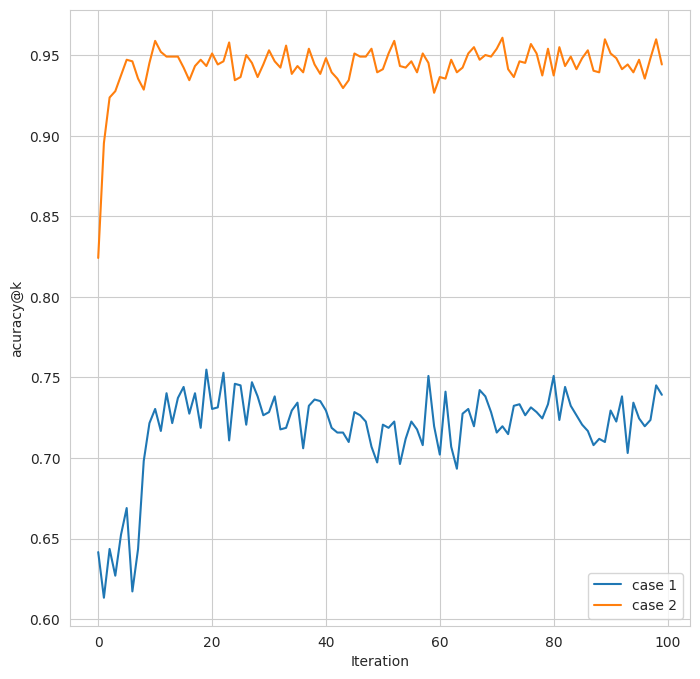

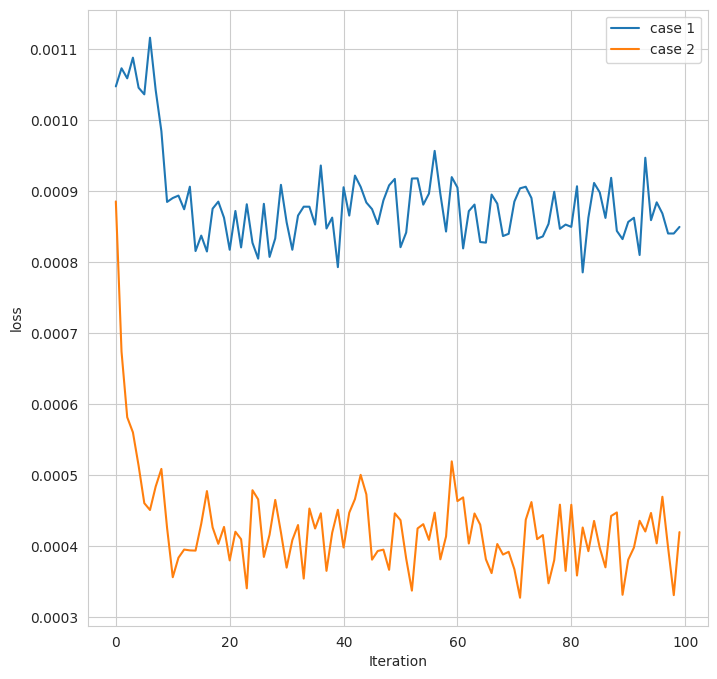

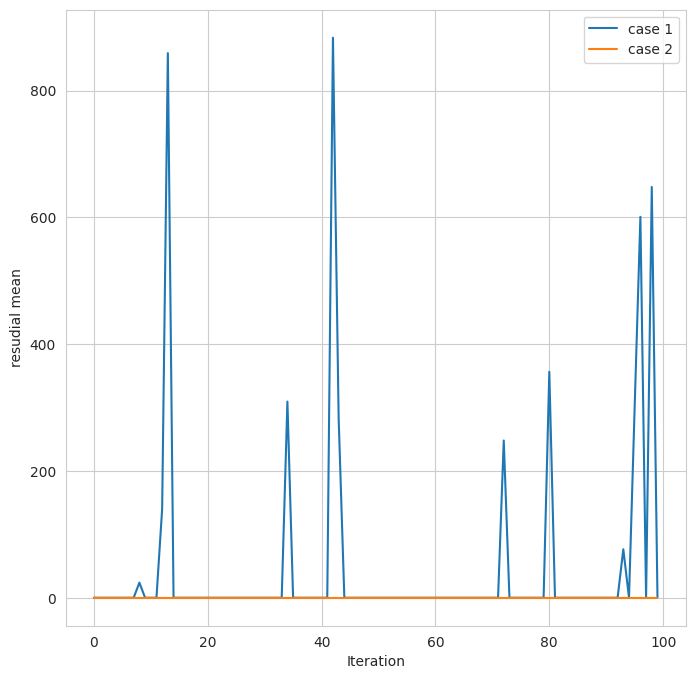

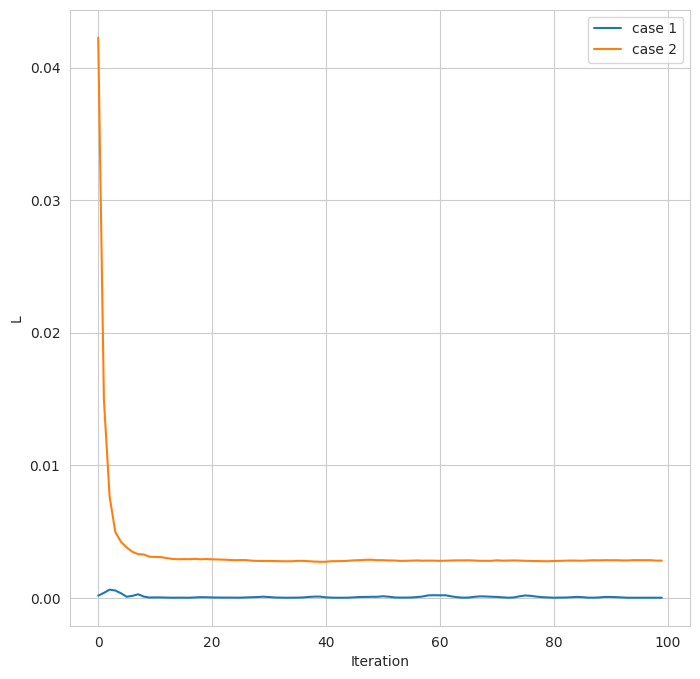

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


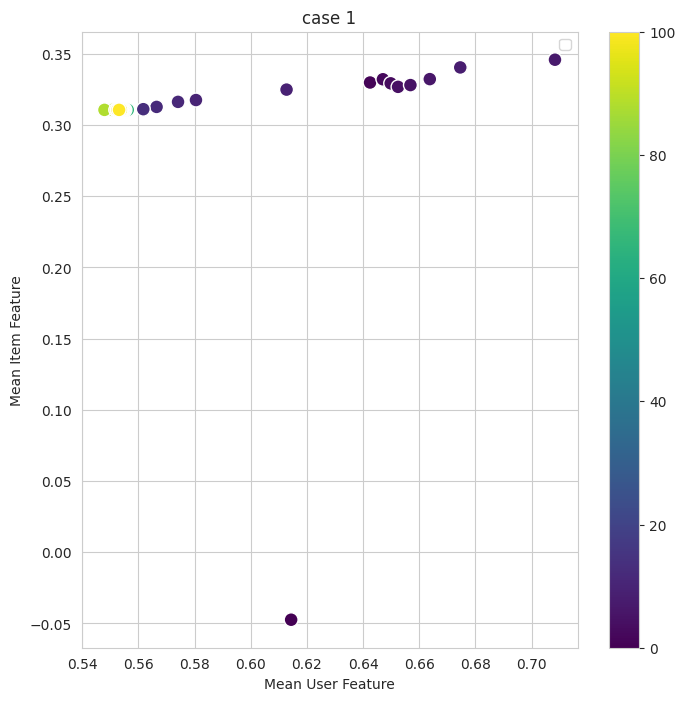

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


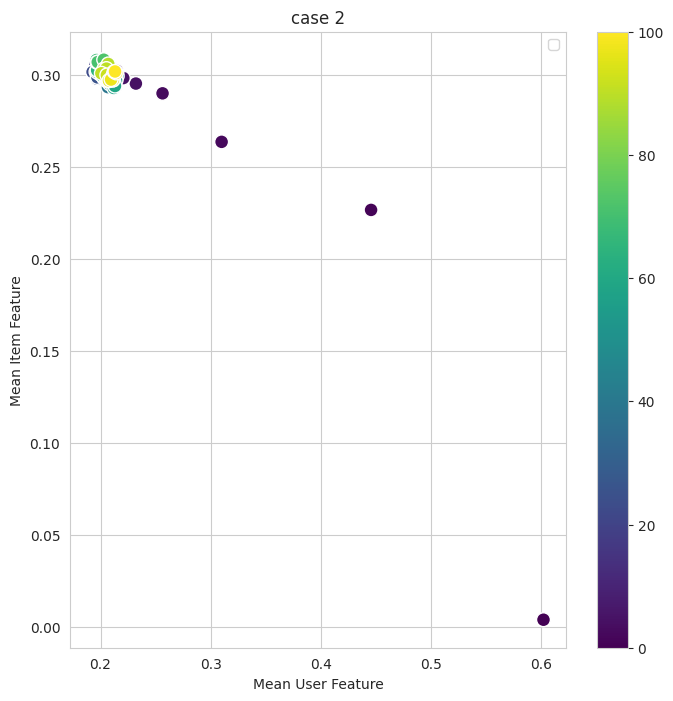

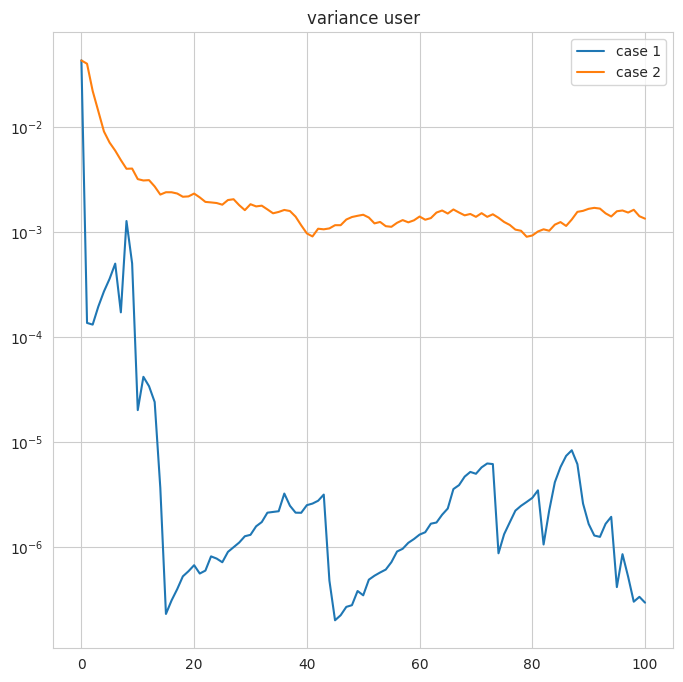

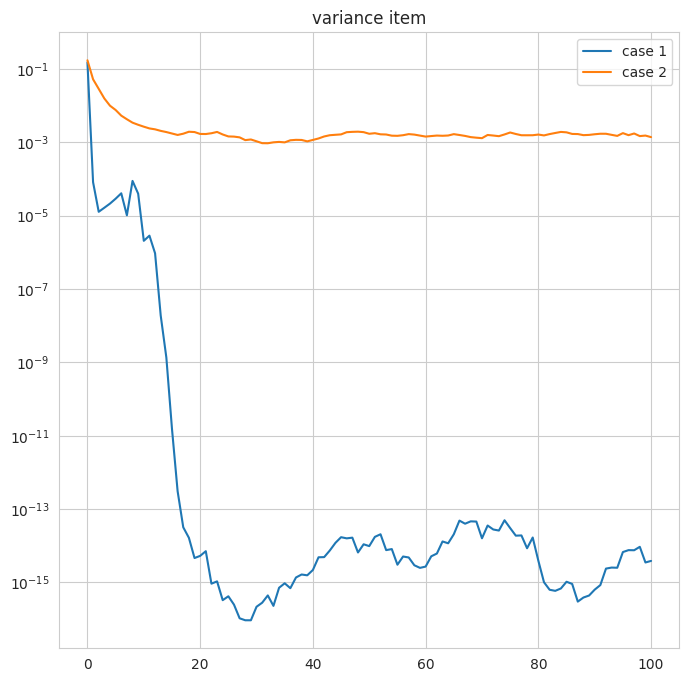

In [15]:
plt.figure(figsize=(8, 8))

plt.plot(np.arange(num_of_iterations - 1), accuracy_1[1:], label="case 1")
plt.plot(np.arange(num_of_iterations - 1), accuracy_2[1:], label="case 2")

plt.xlabel("Iteration")
plt.ylabel("acuracy@k")
plt.legend()
plt.show()

plt.figure(figsize=(8, 8))

plt.plot(np.arange(num_of_iterations - 1), loss_history_1[1:], label="case 1")
plt.plot(np.arange(num_of_iterations - 1), loss_history_2[1:], label="case 2")

plt.xlabel("Iteration")
plt.ylabel("loss")
plt.legend()
plt.show()

plt.figure(figsize=(8, 8))


plt.plot(np.arange(num_of_iterations - 1), residual_history_1[1:], label="case 1")
plt.plot(np.arange(num_of_iterations - 1), residual_history_2[1:], label="case 2")

plt.xlabel("Iteration")
plt.ylabel("resudial mean")
plt.legend()
plt.show()


plt.figure(figsize=(8, 8))

plt.plot(np.arange(num_of_iterations - 1), L_val_1[1:], label="case 1")
plt.plot(np.arange(num_of_iterations - 1), L_val_2[1:], label="case 2")

plt.xlabel("Iteration")
plt.ylabel("L")
plt.legend()
plt.show()

plt.figure(figsize=(8, 8))
plt.title("case 1")

plt.scatter(mean_1[0], mean_1[1], c=np.arange(num_of_iterations), cmap='viridis', edgecolors='w', s=100)
plt.xlabel("Mean User Feature")
plt.ylabel("Mean Item Feature")
plt.colorbar()

plt.legend()

plt.show()

plt.figure(figsize=(8, 8))
plt.title("case 2")
plt.scatter(mean_2[0], mean_2[1], c=np.arange(num_of_iterations), cmap='viridis', edgecolors='w', s=100)
plt.xlabel("Mean User Feature")
plt.ylabel("Mean Item Feature")
plt.colorbar()

plt.legend()

plt.show()

plt.figure(figsize=(8, 8))
plt.title("variance user")
# plt.scatter(variance_1[0], variance_1[1], c=np.arange(num_of_iterations), cmap='viridis', edgecolors='w', s=100)
plt.plot(variance_1[0], label="case 1")
plt.plot(variance_2[0], label="case 2")
plt.yscale("log")
plt.legend()

plt.show()


plt.figure(figsize=(8, 8))
plt.title("case 2")
# plt.scatter(variance_2[0], variance_2[1], c=np.arange(num_of_iterations), cmap='viridis', edgecolors='w', s=100)
plt.title("variance item")
# plt.scatter(variance_1[0], variance_1[1], c=np.arange(num_of_iterations), cmap='viridis', edgecolors='w', s=100)
plt.plot(variance_1[1], label="case 1")
plt.plot(variance_2[1], label="case 2")
plt.yscale("log")

plt.legend()

plt.show()



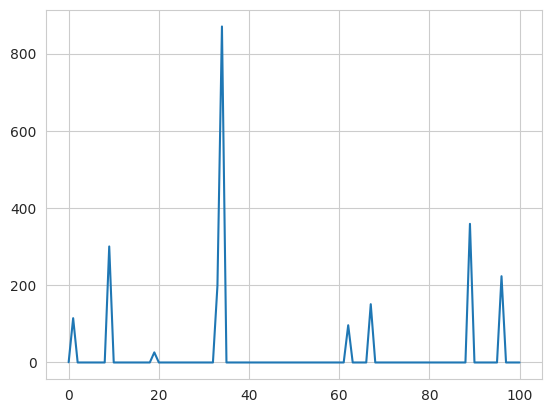

In [14]:
plt.plot(residual_history_1)

In [41]:
class Oracle:
    def recommend_topN(self, user_info, items_to_recommend, topn=10):
        n = min(topn, items_to_recommend.shape[0])
        res = np.array([usefulness(user_info["F"], items_to_recommend["F"].to_numpy(),
                                   epsilon.rvs(items_to_recommend.shape[0]))] * n)
        ids = np.argpartition(res, n - 1)
        return pd.DataFrame({"ItemId": ids[:n], "Rating": res[ids][:n]})

In [42]:
model = Oracle()

In [43]:
from models.CMF_Predictor import CMFRecommender, dynamic_system_iterate_CMF

start_c_size = 128
start_w_size = 128

user_info = pd.DataFrame({"F": customer_distribution.rvs(size=start_c_size)})  # генерим датасет для нулевой итерации
user_info["UserId"] = np.arange(start_c_size)

item_info = pd.DataFrame({"F": w_distribution.rvs(size=start_w_size)})
item_info["ItemId"] = np.arange(start_w_size)
feedback = []

for i, user_row in user_info.iterrows():
    for j, item_row in item_info.iterrows():
        deal = sps.bernoulli.rvs(usefulness(user_row["F"], item_row["F"], epsilon.rvs()))
        feedback.append((user_row["UserId"], item_row["ItemId"], deal))


In [44]:
# feedback = pd.DataFrame(feedback, columns=['UserId', 'ItemId', 'Feedback'])

model = CMFRecommender(capacity=1000000, num_of_factors=300)
model.fit(feedback, user_info, item_info)

  0%|          | 0/101 [00:02<?, ?it/s]


TypeError: print_distributions() missing 1 required positional argument: 'c_w_sample'

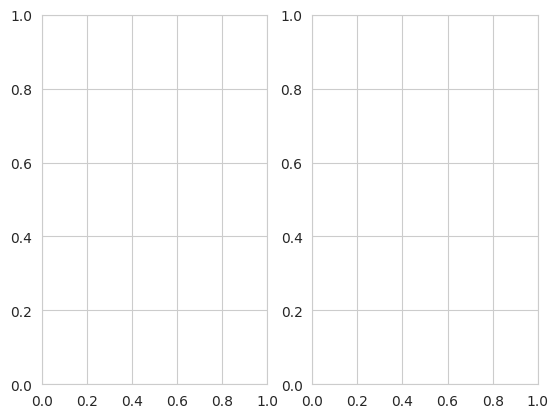

In [45]:
new_cust_distr, new_w_distr = customer_distribution, w_distribution
loss_history = []
residual_history = []
c_size = 128
w_size = 256
big_steps = 101
fig, axs = plt.subplots(ncols=2)
for i in tqdm(range(big_steps)):
    if i % 10 == 0:
        new_cust_distr, new_w_distr, loss, residual = dynamic_system_iterate_CMF(model, usefulness,
                                                                                 epsilon.rvs() / (i + 1),
                                                                                 new_cust_distr,
                                                                                 new_w_distr,
                                                                                 c_size=c_size,
                                                                                 w_size=w_size, topn=8,
                                                                                 delta=1e10,
                                                                                 visualize_distributions=(i, axs))
    else:
        new_cust_distr, new_w_distr, loss, residual = dynamic_system_iterate_CMF(model, usefulness,
                                                                                 epsilon.rvs() / (i + 1),
                                                                                 new_cust_distr,
                                                                                 new_w_distr,
                                                                                 c_size=c_size,
                                                                                 w_size=w_size, topn=8, delta=1e10)
    loss_history.append(loss)
    residual_history.append(residual)
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.show()

In [8]:
loss_history = np.array(loss_history).T

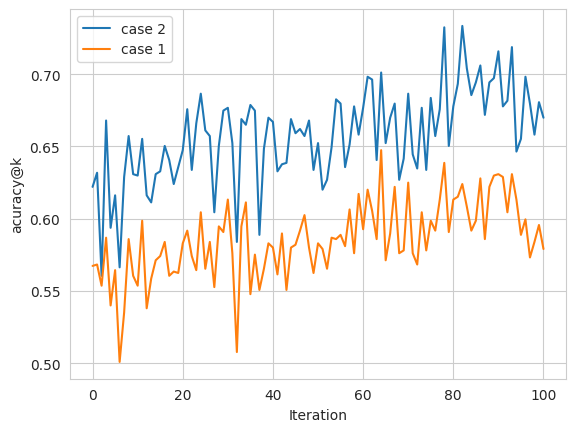

In [9]:
plt.plot(np.arange(big_steps), loss_history[0], label="case 2")
plt.plot(np.arange(big_steps), loss_history[1], label="case 1")

plt.xlabel("Iteration")
plt.ylabel("acuracy@k")
plt.legend()
plt.show()


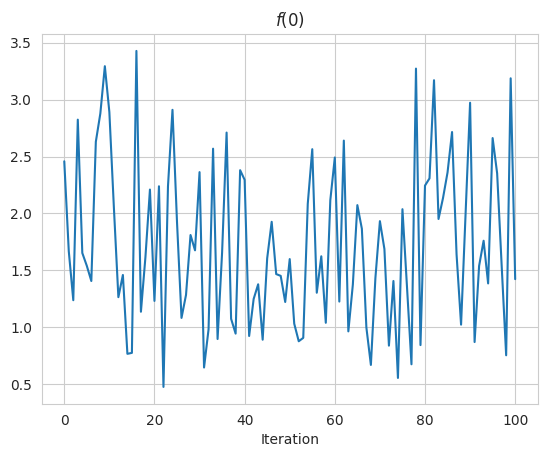

In [10]:
plt.plot(np.arange(big_steps), residual_history)
plt.xlabel("Iteration")
plt.title(r"$f(0)$")
# plt.title(r"$\frac{real \  feedback - predicted \ feedback} {num \ of \ predictions}$")
plt.show()